In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

# Load dataset from Drive
csv_path = '/content/drive/MyDrive/Colab Notebooks/climate_disease_dataset.csv'
df = pd.read_csv(csv_path)

In [ ]:
print("\nDataset shape")
print(df.shape)


Dataset shape
(34560, 12)


In [ ]:
print("\nFirst 5 rows")
print(df.head())


First 5 rows
   year  month                country   region  avg_temp_c  precipitation_mm  \
0  2000      1  Palestinian Territory  Central   28.132468        152.083870   
1  2000      2  Palestinian Territory  Central   30.886500        119.591418   
2  2000      3  Palestinian Territory  Central   31.366433         95.876124   
3  2000      4  Palestinian Territory  Central   28.481870        175.315731   
4  2000      5  Palestinian Territory  Central   26.890370        191.445990   

   air_quality_index   uv_index  malaria_cases  dengue_cases  \
0         110.487231  12.000000             53           145   
1          83.467928  12.000000            132            48   
2          93.095292  12.000000             34            80   
3         105.530192   9.395894             23           133   
4          60.205979   9.935726             39            74   

   population_density  healthcare_budget  
0                 113               1068  
1                 113             

In [ ]:
print("\nColumn dtypes")
print(df.dtypes)


Column dtypes
year                    int64
month                   int64
country                object
region                 object
avg_temp_c            float64
precipitation_mm      float64
air_quality_index     float64
uv_index              float64
malaria_cases           int64
dengue_cases            int64
population_density      int64
healthcare_budget       int64
dtype: object


In [ ]:
print("\nBasic statistics (numeric)")
print(df.describe())


Basic statistics (numeric)
               year         month    avg_temp_c  precipitation_mm  \
count  34560.000000  34560.000000  34560.000000      34560.000000   
mean    2011.500000      6.500000     20.395234        192.667977   
std        6.922287      3.452102      8.410940         90.503990   
min     2000.000000      1.000000     -2.557056          0.000000   
25%     2005.750000      3.750000     14.404089        124.641424   
50%     2011.500000      6.500000     20.351749        195.315309   
75%     2017.250000      9.250000     26.342978        260.147603   
max     2023.000000     12.000000     44.583564        485.704079   

       air_quality_index      uv_index  malaria_cases  dengue_cases  \
count       34560.000000  34560.000000   34560.000000  34560.000000   
mean           43.787766     10.210855      70.519560     75.941464   
std            33.079697      1.936540      46.130774     37.323807   
min             0.000000      0.870704       0.000000      0.00000

**Checking if there are any NUll or missing values**:

In [ ]:
print("\n=== Missing values per column ===")
missing = df.isnull().sum()
print(missing[missing > 0])


=== Missing values per column ===
Series([], dtype: int64)


No missing value in Dataset

**Checking for the Duplicate values**:

In [ ]:
n_dup = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {n_dup}")


Number of duplicate rows: 0


No duplicate row in dataset

**Checking for categorial columns and unique values per column:**

In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")

for col in cat_cols:
    print(f"\n  • {col} – unique values: {df[col].nunique()}")
    print(df[col].value_counts().head(6))


Categorical columns (2): ['country', 'region']

  • country – unique values: 120
country
Palestinian Territory                           288
Macao                                           288
Antarctica (the territory South of 60 deg S)    288
Slovenia                                        288
Saint Helena                                    288
Japan                                           288
Name: count, dtype: int64

  • region – unique values: 5
region
West       8640
Central    7776
North      6912
South      6912
East       4320
Name: count, dtype: int64


**For implementing Random Forest all the categorical values will be encoded**

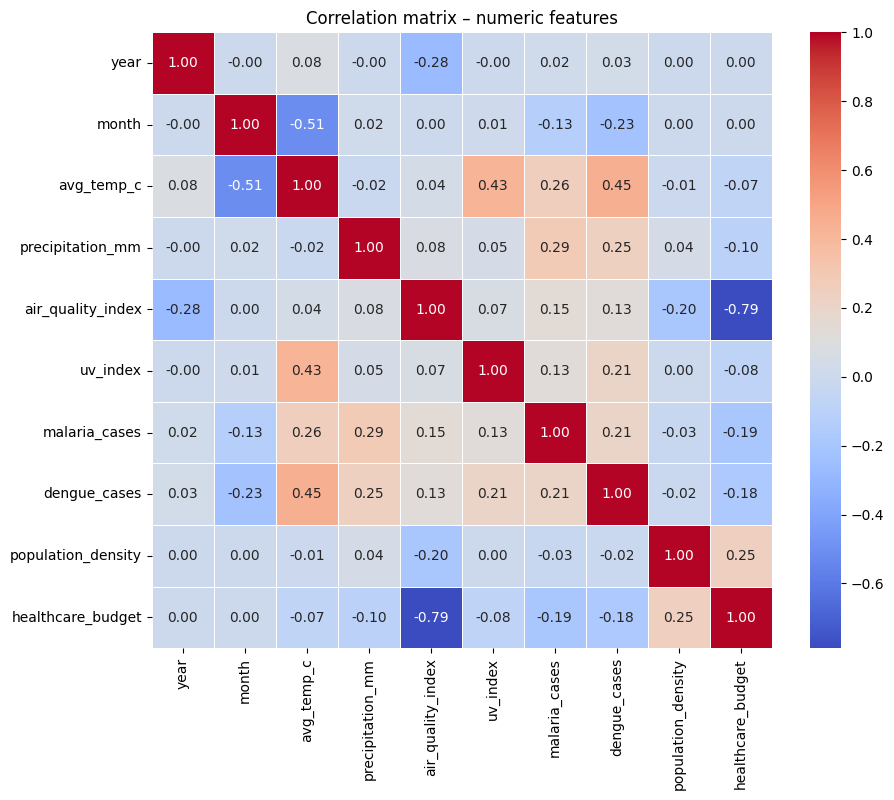

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Correlation matrix – numeric features")
plt.show()

**Checking for the outliers**

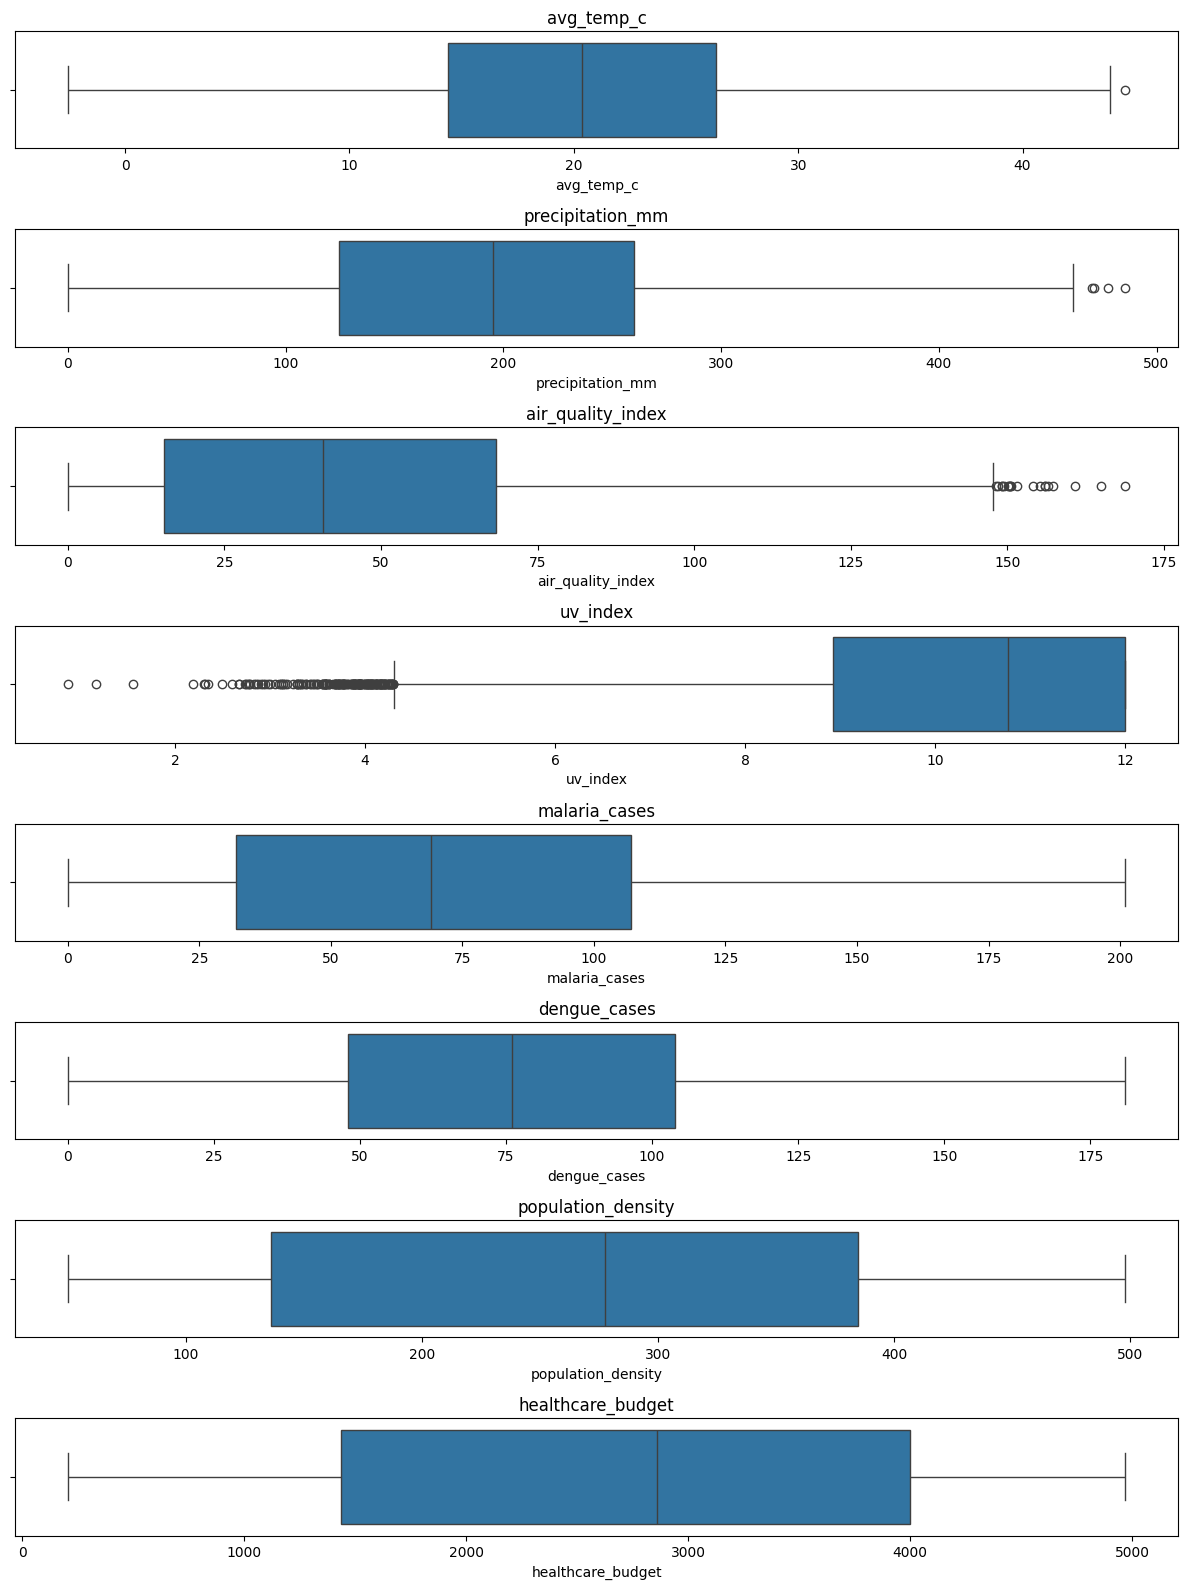

In [ ]:
plot_cols = ['avg_temp_c', 'precipitation_mm', 'air_quality_index',
             'uv_index', 'malaria_cases', 'dengue_cases',
             'population_density', 'healthcare_budget']

plt.figure(figsize=(12, len(plot_cols)*2))
for i, col in enumerate(plot_cols, 1):
    plt.subplot(len(plot_cols), 1, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

**Pie chart for Visulizing data for each region**

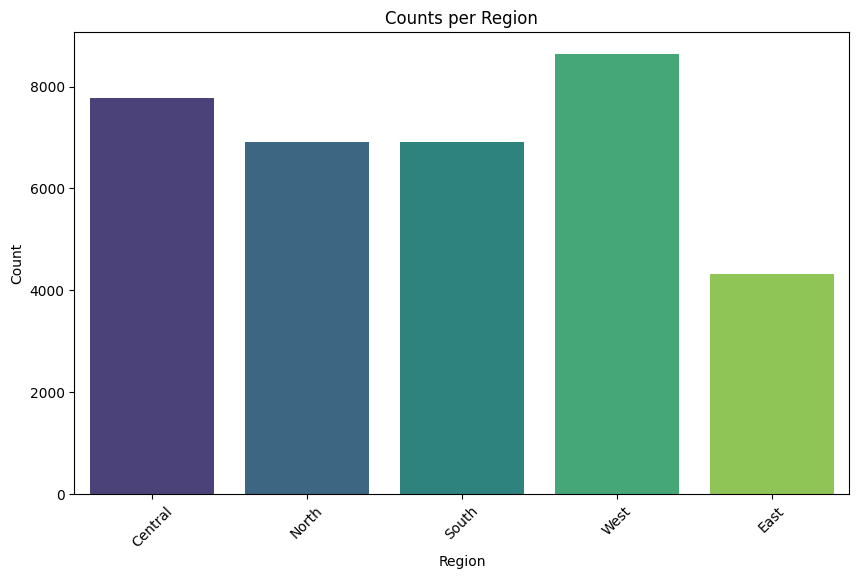

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='region', hue='region', palette='viridis')
plt.title('Counts per Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


**Average Teperature by region**

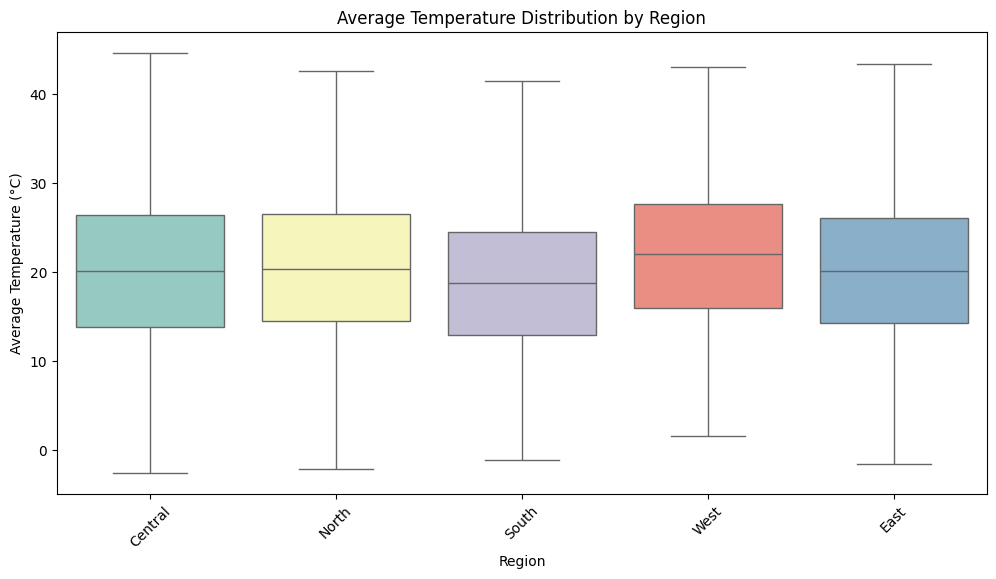

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='region', y='avg_temp_c', hue='region', palette='Set3')
plt.title('Average Temperature Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
data = df.copy()

**Encoding the categorical Columns**

In [ ]:
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

**Cliping the extreme outliers**

In [ ]:
numeric_features = [c for c in num_cols if c not in ['malaria_cases', 'dengue_cases']]
for col in numeric_features:
    lower, upper = data[col].quantile([0.01, 0.99])
    data[col] = np.clip(data[col], lower, upper)

**Creating Date time column for spliting the data for test and traning**

In [ ]:
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))
data = data.drop(['year', 'month'], axis=1)

**Specifying the targets and the features**

In [ ]:
X = data.drop(['malaria_cases', 'dengue_cases', 'date'], axis=1)
y = data[['malaria_cases', 'dengue_cases']]

In [ ]:
print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")
print("Columns in X (first 10):", X.columns[:10].tolist())

X shape : (34560, 129)
y shape : (34560, 2)
Columns in X (first 10): ['avg_temp_c', 'precipitation_mm', 'air_quality_index', 'uv_index', 'population_density', 'healthcare_budget', 'country_Antarctica (the territory South of 60 deg S)', 'country_Antigua and Barbuda', 'country_Armenia', 'country_Aruba']


In [ ]:
X.to_csv('X_preprocessed.csv', index=False)
y.to_csv('y_preprocessed.csv', index=False)

**Implementing Random Forest**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X = pd.read_csv('X_preprocessed.csv')
y = pd.read_csv('y_preprocessed.csv')

In [ ]:
min_year = df['year'].min()
max_year = df['year'].max()

print(f"Year range in dataset: {min_year} - {max_year}")
X['year'] = df['year']

Year range in dataset: 2000 - 2023


**Split on the basis of years**

In [ ]:
train = X[X['year'] <= 2021]
test  = X[X['year'] >= 2022]

X_train = train.drop(['malaria_cases', 'dengue_cases', 'date'], axis=1, errors='ignore')
y_train = y.loc[train.index]

X_test  = test.drop(['malaria_cases', 'dengue_cases', 'date'], axis=1, errors='ignore')
y_test  = y.loc[test.index]


**Split the data on the basis of date 80% traning and 20% testing**

In [ ]:
# if 'date' in X.columns:
#     X = X.sort_values('date')
#     y = y.reindex(X.index)
#     split_idx = int(0.8 * len(X))
#     X_train = X.iloc[:split_idx].drop('date', axis=1)
#     X_test = X.iloc[split_idx:].drop('date', axis=1)
#     y_train = y.iloc[:split_idx]
#     y_test = y.iloc[split_idx:]
# else:
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Training model on training data**

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

**Predicting on the test data**

In [ ]:
y_pred = rf_model.predict(X_test)

**Evaluating Mean Square Error**

In [ ]:
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("MSE for malaria_cases:", mse[0])
print("MSE for dengue_cases:", mse[1])

MSE for malaria_cases: 1881.9492715624995
MSE for dengue_cases: 1049.5258563541695


In [ ]:
rmse = np.sqrt(mse)
print("RMSE for malaria_cases:", rmse[0])
print("RMSE for dengue_cases:", rmse[1])

RMSE for malaria_cases: 43.381439251856314
RMSE for dengue_cases: 32.396386470626155


In [ ]:
malaria_min = df['malaria_cases'].min()
malaria_max = df['malaria_cases'].max()
print(f"Malaria cases range: {malaria_min} to {malaria_max}")

dengue_min = df['dengue_cases'].min()
dengue_max = df['dengue_cases'].max()
print(f"Dengue cases range: {dengue_min} to {dengue_max}")


Malaria cases range: 0 to 201
Dengue cases range: 0 to 181


R-squared for malaria_cases: 0.11
R-squared for dengue_cases: 0.26


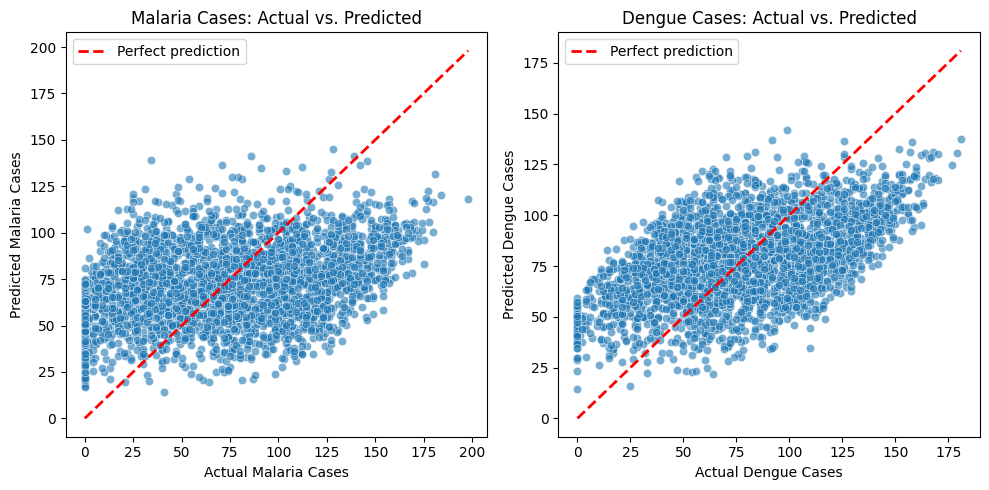

In [ ]:
r2_malaria = r2_score(y_test['malaria_cases'], y_pred[:, 0])
print(f"R-squared for malaria_cases: {r2_malaria:.2f}")

r2_dengue = r2_score(y_test['dengue_cases'], y_pred[:, 1])
print(f"R-squared for dengue_cases: {r2_dengue:.2f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test['malaria_cases'], y=y_pred[:, 0], alpha=0.6)
plt.plot([y_test['malaria_cases'].min(), y_test['malaria_cases'].max()],
         [y_test['malaria_cases'].min(), y_test['malaria_cases'].max()],
         'r--', lw=2, label='Perfect prediction')
plt.title('Malaria Cases: Actual vs. Predicted')
plt.xlabel('Actual Malaria Cases')
plt.ylabel('Predicted Malaria Cases')
plt.legend()


plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test['dengue_cases'], y=y_pred[:, 1], alpha=0.6)
plt.plot([y_test['dengue_cases'].min(), y_test['dengue_cases'].max()],
         [y_test['dengue_cases'].min(), y_test['dengue_cases'].max()],
         'r--', lw=2, label='Perfect prediction')
plt.title('Dengue Cases: Actual vs. Predicted')
plt.xlabel('Actual Dengue Cases')
plt.ylabel('Predicted Dengue Cases')
plt.legend()

plt.tight_layout()
plt.show()

**Feature Engineering**

**Add Lags and rolling features per group**

Group is of combining country and region

In [ ]:
def add_lags(df, group_cols=['country', 'region'], targets=['malaria_cases', 'dengue_cases'], lags=[1,2,3,6,12], rolls=[3,6]):
    df = df.sort_values(by=group_cols + ['year', 'month']).reset_index(drop=True)
    for target in targets:
        for lag in lags:
            df[f'{target}_lag_{lag}'] = df.groupby(group_cols)[target].shift(lag)
        for roll in rolls:
            df[f'{target}_roll_mean_{roll}'] = df.groupby(group_cols)[target].transform(lambda x: x.rolling(roll, min_periods=1).mean())
            df[f'{target}_roll_std_{roll}'] = df.groupby(group_cols)[target].transform(lambda x: x.rolling(roll, min_periods=1).std())
    return df

In [ ]:
df = add_lags(df)

In [ ]:
print(df.head())

   year  month         country region  avg_temp_c  precipitation_mm  \
0  2000      1  American Samoa   East   24.046880        275.221450   
1  2000      2  American Samoa   East   27.865871        257.518897   
2  2000      3  American Samoa   East   27.185394        118.270513   
3  2000      4  American Samoa   East   25.036525        179.148943   
4  2000      5  American Samoa   East   24.675325        228.473663   

   air_quality_index   uv_index  malaria_cases  dengue_cases  ...  \
0          32.664808  10.092419              7            36  ...   
1           6.549863   9.489863            136           120  ...   
2          26.385328  12.000000             53            79  ...   
3          12.735504  12.000000             34            82  ...   
4          10.127494  12.000000             85           128  ...   

   malaria_cases_roll_std_6  dengue_cases_lag_1  dengue_cases_lag_2  \
0                       NaN                 NaN                 NaN   
1               

In [ ]:
df = df.fillna(0)

In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
print(df.head())

   year  month         country region  avg_temp_c  precipitation_mm  \
0  2000      1  American Samoa   East   24.046880        275.221450   
1  2000      2  American Samoa   East   27.865871        257.518897   
2  2000      3  American Samoa   East   27.185394        118.270513   
3  2000      4  American Samoa   East   25.036525        179.148943   
4  2000      5  American Samoa   East   24.675325        228.473663   

   air_quality_index   uv_index  malaria_cases  dengue_cases  ...  \
0          32.664808  10.092419              7            36  ...   
1           6.549863   9.489863            136           120  ...   
2          26.385328  12.000000             53            79  ...   
3          12.735504  12.000000             34            82  ...   
4          10.127494  12.000000             85           128  ...   

   dengue_cases_lag_1  dengue_cases_lag_2  dengue_cases_lag_3  \
0                 NaN                 NaN                 NaN   
1                36.0       

In [ ]:
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['quarter'] = df['date'].dt.quarter
print(df.head())

   year  month         country region  avg_temp_c  precipitation_mm  \
0  2000      1  American Samoa   East   24.046880        275.221450   
1  2000      2  American Samoa   East   27.865871        257.518897   
2  2000      3  American Samoa   East   27.185394        118.270513   
3  2000      4  American Samoa   East   25.036525        179.148943   
4  2000      5  American Samoa   East   24.675325        228.473663   

   air_quality_index   uv_index  malaria_cases  dengue_cases  ...  \
0          32.664808  10.092419              7            36  ...   
1           6.549863   9.489863            136           120  ...   
2          26.385328  12.000000             53            79  ...   
3          12.735504  12.000000             34            82  ...   
4          10.127494  12.000000             85           128  ...   

   dengue_cases_lag_12  dengue_cases_roll_mean_3  dengue_cases_roll_std_3  \
0                  NaN                 36.000000                      NaN   
1   

In [ ]:
cat_cols = ['country', 'region']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

KeyError: "None of [Index(['country', 'region'], dtype='object')] are in the [columns]"

In [ ]:
print(df.head())

   year  month  avg_temp_c  precipitation_mm  air_quality_index   uv_index  \
0  2000      1   24.046880        275.221450          32.664808  10.092419   
1  2000      2   27.865871        257.518897           6.549863   9.489863   
2  2000      3   27.185394        118.270513          26.385328  12.000000   
3  2000      4   25.036525        179.148943          12.735504  12.000000   
4  2000      5   24.675325        228.473663          10.127494  12.000000   

   malaria_cases  dengue_cases  population_density  healthcare_budget  ...  \
0              7            36                 289               4667  ...   
1            136           120                 289               4667  ...   
2             53            79                 289               4667  ...   
3             34            82                 289               4667  ...   
4             85           128                 289               4667  ...   

   country_Turkmenistan  country_Tuvalu  country_United Arab E

In [ ]:
X = df.drop(['malaria_cases', 'dengue_cases', 'date'], axis=1)
y = df[['malaria_cases', 'dengue_cases']]

**Split the data on basis of time**

In [ ]:
train_mask = df['year'] <= 2021
test_mask = df['year'] >= 2022

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("MSE for malaria_cases:", mse[0])
print("MSE for dengue_cases:", mse[1])

rmse = np.sqrt(mse)
print("RMSE for malaria_cases:", rmse[0])
print("RMSE for dengue_cases:", rmse[1])

r2_malaria = r2_score(y_test['malaria_cases'], y_pred[:, 0])
print(f"R-squared for malaria_cases: {r2_malaria:.2f}")

r2_dengue = r2_score(y_test['dengue_cases'], y_pred[:, 1])
print(f"R-squared for dengue_cases: {r2_dengue:.2f}")

MSE for malaria_cases: 119.79073638888899
MSE for dengue_cases: 241.69438260416732
RMSE for malaria_cases: 10.944895448970218
RMSE for dengue_cases: 15.546523167710758
R-squared for malaria_cases: 0.94
R-squared for dengue_cases: 0.83


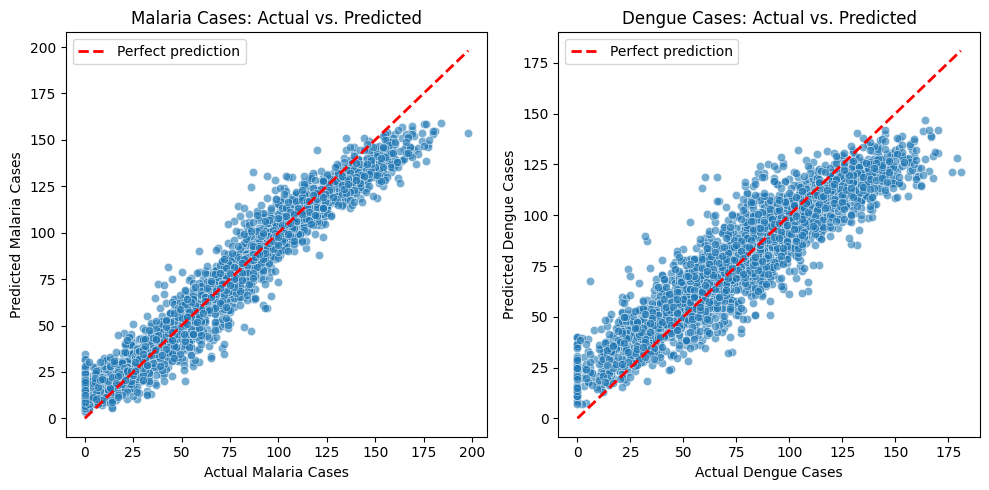

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test['malaria_cases'], y=y_pred[:, 0], alpha=0.6)
plt.plot([y_test['malaria_cases'].min(), y_test['malaria_cases'].max()],
         [y_test['malaria_cases'].min(), y_test['malaria_cases'].max()],
         'r--', lw=2, label='Perfect prediction')
plt.title('Malaria Cases: Actual vs. Predicted')
plt.xlabel('Actual Malaria Cases')
plt.ylabel('Predicted Malaria Cases')
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test['dengue_cases'], y=y_pred[:, 1], alpha=0.6)
plt.plot([y_test['dengue_cases'].min(), y_test['dengue_cases'].max()],
         [y_test['dengue_cases'].min(), y_test['dengue_cases'].max()],
         'r--', lw=2, label='Perfect prediction')
plt.title('Dengue Cases: Actual vs. Predicted')
plt.xlabel('Actual Dengue Cases')
plt.ylabel('Predicted Dengue Cases')
plt.legend()

plt.tight_layout()
plt.show()

**Download the model**

In [ ]:
import joblib

joblib.dump(rf_model, "random_forest_model.pkl")
print("Model saved!")


Model saved!


In [152]:
from google.colab import files
files.download("random_forest_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [153]:
from google.colab import files

files.download('/content/Untitled1.ipynb')


FileNotFoundError: Cannot find file: /content/Untitled1.ipynb